In [1]:
from IPython.display import Image

このチュートリアルでは、「畳み込みニューラルネットワーク (Convolutional Neural Network:CNN)を用いた画像認識タスク」をテーマに取り上げ、CNTK でどのように実装するのかについて、step by step で学んでいただくことを目的にしています。
具体的には以下に取り組んでいただきます。

# 使用するデータセット

本ハンズオンでは、画像認識タスクのベンチマークとしてよく使われる「CIFAR-10」という画像データセットを使用します。

In [4]:
# Figure 1
Image(url="https://cntk.ai/jup/201/cifar-10.png", width=500, height=500)

CIFAR-10は、約 8000 万枚の画像がある 80 Million Tiny Images 
からサブセットとして約 6 万枚の画像を抽出してラベル付けしたものです。
CIFAR-10 は、上図のように、10 クラスがラベル付けされており、訓練画像: 50000枚
(各クラス 5000枚)、テスト画像: 10000枚(各クラス 1000枚) に分割されています。

CNIFAR-10は CNTK ディストーションに含まれはいませんが、簡単にダウンロードでき、CNTK サポータブルなフォーマットに変換することが可能です。

本ハンズオンでは、すでにCNTK supportable な　convert 済みの CIFAR-10 をすでにご用意していますが、convert するやり方については、CNTK 公式のチュートリアルの中にある 
[こちら](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_201A_CIFAR-10_DataLoader.ipynb) に詳しく紹介されていますのでそちらをご覧ください。


## CNTK workflow

1. reader
    * minibatch source
    * task-specific deserializer 
2. network
    * model function
    * criterion function
3. trainer
    * SGD(momentum, Adam, ...)
    * minibatching






In [64]:
Image(url="https://cntk.ai/jup/201/CNN.png")

In [65]:
from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from cntk.utils import *

# 1. reader 


<画像データのフルパス> <タブ> <正解ラベル>

Example of a map text file:

    S:\data\CIFAR-10\train\00001.png	9
    S:\data\CIFAR-10\train\00002.png	9
    S:\data\CIFAR-10\train\00003.png	4
    S:\data\CIFAR-10\train\00004.png	1
    S:\data\CIFAR-10\train\00005.png	1




In [75]:
from cntk.io import MinibatchSource, ImageDeserializer, StreamDef, StreamDefs
import cntk.io.transforms as xforms 



# model dimensions
image_height = 32
image_width  = 32
num_channels = 3
num_classes  = 10


#
# Define the reader for both training and evaluation action.
#
def create_reader(map_file, mean_file, train):

    # transformation pipeline for the features has jitter/crop only when training
    transforms = []
    if train:
        transforms += [
            xforms.crop(crop_type='randomside', side_ratio=0.8, jitter_type='uniRatio') # train uses data augmentation (translation only)
        ]
    transforms += [
        xforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear'),
        xforms.mean(mean_file)
    ]
    # deserializer
    return MinibatchSource(ImageDeserializer(map_file, StreamDefs(
        features = StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )))


# 2. network

上図の CNN をストレートに実装したのが以下です。

In [46]:
from cntk.layers import Convolution, MaxPooling, Dense
from cntk.initializer import glorot_uniform
from cntk.ops import relu

def create_model(input, out_dims):
    
    net = Convolution((5,5), 32, init=glorot_uniform(), activation=relu, pad=True)(input)
    net = MaxPooling((3,3), strides=(2,2))(net)

    net = Convolution((5,5), 32, init=glorot_uniform(), activation=relu, pad=True)(net)
    net = MaxPooling((3,3), strides=(2,2))(net)

    net = Convolution((5,5), 64, init=glorot_uniform(), activation=relu, pad=True)(net)
    net = MaxPooling((3,3), strides=(2,2))(net)
    
    net = Dense(64, init=glorot_uniform())(net)
    net = Dense(out_dims, init=glorot_uniform(), activation=None)(net)
    
    return net

## Layers ライブラリ を使ってモデルを定義しよう

CNTK には、簡潔にネットワークを定義するために、一般的な (例えば、全結合層や convolution 層など) ニューラルネットワークにおける各層が "Layers" と呼ばれるライブラリの形で事前に定義されています。Layers は関数オブジェクトとして定義されているため、とても巨大で複雑な**関数の集合体**であるニューラルネットワークをより直感的に書くことができます。


## Sequential()
Sequential() は、ネットワークをコンパクトに書く上で非常に便利なオペレーションです。


図の挿入 


例えば、上図のような、一般的な 4層 feedforward なニューラルネットワークを実装
しようとした場合、以下のように書きます。

```py
my_model = Sequential ([
# 活性化関数に sigmoid を使う 4 つの隠れ層
    Dense(2048, activation=sigmoid),  
    Dense(2048, activation=sigmoid),
    Dense(2048, activation=sigmoid),
    Dense(2048, activation=sigmoid),
    # 最後の層(出力層) は活性化関数が softmax
    Dense(9000, activation=softmax)   
])
```

## For()

For() は、定義した lambda 式 をリピート実行することよって、系列モデルを構築することができます。

For() を使うと先ほどの 4層 feedforward なニューラルネットワークもよりコンパクトに書けます。

```py

with default_options(activation=sigmoid):
    my_model = Sequential([
        For(range(4), lambda: Dense(2048)),
        Dense(9000, activation=softmax)
    ])
      
```


## ★ Let's Try 1 : Sequential() や For() を使って、CNN モデルを書いてみよう！


In [76]:
from cntk.layers import Convolution, MaxPooling, Dense, default_options, Sequential, For
from cntk.initializer import glorot_uniform
from cntk.ops import relu

def create_basic_model(input, out_dims):

    with default_options(activation=relu):
        model = Sequential([
            For(range(3), lambda i: [
                Convolution((5,5), [32,32,64][i], init=glorot_uniform(), pad=True),
                MaxPooling((3,3), strides=(2,2))
            ]),
            Dense(64, init=glorot_uniform()),
            Dense(out_dims, init=glorot_uniform(), activation=None)
        ])

    return model(input)

# 3. trainer (and evaluator)

## Trainer を使って、モデルを学習しよう

Trainer は学習に必要な全てのものをカプセル化するクラスです。それは主に以下のような
ものを保持します。

* model 
* criterion
* parameter_learners
    * 学習率  (learning rate)
    * 学習アルゴリズム
    
    
**[復習]** ニューラルネットワークの学習
1. 訓練データの中からランダムに一部のデータ(ミニバッチ)を選び出しモデルに渡す
2. ミニバッチを入力層→出力層へと順番に伝播させていき、最後の出力層で値を出力する
3. 出力結果と正解ラベルを比較し、損失関数を減らすために、各重みパラメータの勾配を計算する
4. 重みパラメータを勾配方向に微小量だけ更新する (パラメータの更新)
5. 1-4 を繰り返す


In [79]:
#
# Train and evaluate the network.
#

from cntk.learner import momentum_sgd, learning_rate_schedule, UnitType, momentum_as_time_constant_schedule
from cntk import Trainer
from cntk.ops import cross_entropy_with_softmax, classification_error, input_variable, softmax, element_times



def train_and_evaluate(reader_train, reader_test, max_epochs, model_func):
    
    # Input variables denoting the features and label data
    input_var = input_variable((num_channels, image_height, image_width))
    label_var = input_variable((num_classes))

    # Normalize the input
    feature_scale = 1.0 / 256.0
    input_var_norm = element_times(feature_scale, input_var)
    
    # apply model to input
    z = model_func(input_var_norm, out_dims=10)

    #
    # Training action
    #

    # loss and metric
    ce = cross_entropy_with_softmax(z, label_var)
    pe = classification_error(z, label_var)

    # training config
    epoch_size     = 50000
    minibatch_size = 64

    # Set training parameters

    lr_per_minibatch       = learning_rate_schedule([0.01]*10 + [0.003]*10 + [0.001], UnitType.minibatch, epoch_size)
    momentum_time_constant = momentum_as_time_constant_schedule(-minibatch_size/np.log(0.9))
    l2_reg_weight          = 0.001
    
    # trainer object
    learner = momentum_sgd(z.parameters, 
                           lr = lr_per_minibatch, momentum = momentum_time_constant, 
                           l2_regularization_weight=l2_reg_weight)
    progress_printer = ProgressPrinter(tag='Training', num_epochs=max_epochs)
    trainer = Trainer(z, (ce, pe), [learner], [progress_printer])

    # define mapping from reader streams to network inputs
    input_map = {
        input_var: reader_train.streams.features,
        label_var: reader_train.streams.labels
    }

    log_number_of_parameters(z) ; print()

    # Get minibatches of image to train with and perform model training
    batch_index = 0
    plot_data = {'batchindex':[], 'loss':[], 'error':[]}
    for epoch in range(max_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = reader_train.next_minibatch(min(minibatch_size, epoch_size - sample_count), input_map=input_map) # fetch minibatch.
            trainer.train_minibatch(data)                                   # update model with it
            sample_count += data[label_var].num_samples                     # count samples processed so far
            
            # For visualization...            
            plot_data['batchindex'].append(batch_index)
            plot_data['loss'].append(trainer.previous_minibatch_loss_average)
            plot_data['error'].append(trainer.previous_minibatch_evaluation_average)
            
            batch_index += 1
        trainer.summarize_training_progress()
        
    #
    # Evaluation action
    #
    epoch_size     = 10000
    minibatch_size = 16

    # process minibatches and evaluate the model
    metric_numer    = 0
    metric_denom    = 0
    sample_count    = 0
    minibatch_index = 0

    while sample_count < epoch_size:
        current_minibatch = min(minibatch_size, epoch_size - sample_count)

        # Fetch next test min batch.
        data = reader_test.next_minibatch(current_minibatch, input_map=input_map)

        # minibatch data to be trained with
        metric_numer += trainer.test_minibatch(data) * current_minibatch
        metric_denom += current_minibatch

        # Keep track of the number of samples processed so far.
        sample_count += data[label_var].num_samples
        minibatch_index += 1

    print("")
    print("Final Results: Minibatch[1-{}]: errs = {:0.1f}% * {}".format(minibatch_index+1, (metric_numer*100.0)/metric_denom, metric_denom))
    print("")
    
    # Visualize training result:
    window_width            = 32
    loss_cumsum             = np.cumsum(np.insert(plot_data['loss'], 0, 0)) 
    error_cumsum            = np.cumsum(np.insert(plot_data['error'], 0, 0)) 

    # Moving average.
    plot_data['batchindex'] = np.insert(plot_data['batchindex'], 0, 0)[window_width:]
    plot_data['avg_loss']   = (loss_cumsum[window_width:] - loss_cumsum[:-window_width]) / window_width
    plot_data['avg_error']  = (error_cumsum[window_width:] - error_cumsum[:-window_width]) / window_width
    
    plt.figure(1)
    plt.subplot(211)
    plt.plot(plot_data["batchindex"], plot_data["avg_loss"], 'b--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.title('Minibatch run vs. Training loss ')

    plt.show()

    plt.subplot(212)
    plt.plot(plot_data["batchindex"], plot_data["avg_error"], 'r--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Label Prediction Error')
    plt.title('Minibatch run vs. Label Prediction Error ')
    plt.show()
    
    return softmax(z)

Training 116906 parameters in 10 parameter tensors.

Finished Epoch[1 of 10]: [Training] loss = 2.105739 * 50000, metric = 77.75% * 50000 465.607s (107.4 samples/s);
Finished Epoch[2 of 10]: [Training] loss = 1.730657 * 50000, metric = 63.26% * 50000 470.985s (106.2 samples/s);
Finished Epoch[3 of 10]: [Training] loss = 1.551445 * 50000, metric = 57.10% * 50000 489.892s (102.1 samples/s);
Finished Epoch[4 of 10]: [Training] loss = 1.455622 * 50000, metric = 52.57% * 50000 473.757s (105.5 samples/s);
Finished Epoch[5 of 10]: [Training] loss = 1.369543 * 50000, metric = 49.34% * 50000 464.593s (107.6 samples/s);
Finished Epoch[6 of 10]: [Training] loss = 1.299427 * 50000, metric = 46.30% * 50000 474.191s (105.4 samples/s);
Finished Epoch[7 of 10]: [Training] loss = 1.234507 * 50000, metric = 43.93% * 50000 482.476s (103.6 samples/s);
Finished Epoch[8 of 10]: [Training] loss = 1.178415 * 50000, metric = 41.56% * 50000 474.018s (105.5 samples/s);
Finished Epoch[9 of 10]: [Training] loss = 

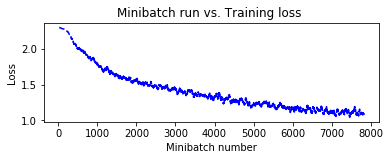

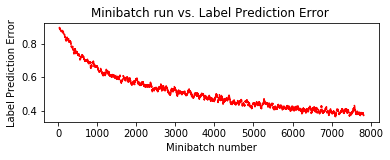

In [81]:
data_path = os.path.join('data', 'CIFAR-10')
reader_train = create_reader(os.path.join(data_path, 'train_map.txt'), os.path.join(data_path, 'CIFAR-10_mean.xml'), True)
reader_test  = create_reader(os.path.join(data_path, 'test_map.txt'), os.path.join(data_path, 'CIFAR-10_mean.xml'), False)

pred = train_and_evaluate(reader_train, reader_test, max_epochs=10, model_func=create_basic_model)

# コメント

## 学習済みモデルを使った予測
先ほど学習したモデルを使って実際にいつくつかのテスト画像を分類させてみましょう。

In [28]:
# Figure 6
Image(url="https://cntk.ai/jup/201/00014.png", width=64, height=64)

In [29]:
import PIL

def eval(pred_op, image_path):
    label_lookup = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    image_mean   = 133.0
    image_data   = np.array(PIL.Image.open(image_path), dtype=np.float32)
    image_data  -= image_mean
    image_data   = np.ascontiguousarray(np.transpose(image_data, (2, 0, 1)))
    
    result       = np.squeeze(pred_op.eval({pred_op.arguments[0]:[image_data]}))
    
    # Return top 3 results:
    top_count = 3
    result_indices = (-np.array(result)).argsort()[:top_count]
    
    
    print("Top 3 predictions:")
    for i in range(top_count):
        print("\tLabel: {:10s}, confidence: {:.2f}%".format(label_lookup[result_indices[i]], result[result_indices[i]] * 100))

In [31]:
eval(pred, "data/CIFAR-10/test/00014.png")

Top 3 predictions:
	Label: truck     , confidence: 49.96%
	Label: frog      , confidence: 25.73%
	Label: automobile, confidence: 8.26%


## Dropout
Dropout は、過学習を抑制するために提唱された手法です。
過学習 (Overfitting) とは、機械学習において、訓練データに対して学習されるが、未知のデータに対して適合できていない (汎化できていない) 状態を指します。特にニューラルネットワークのようにパラメータを大量に持ち、自由度の高いモデルは **過学習に陥りやすい** と言われています。

Dropout では、ニューラルネットワークを学習する際に、ノードをランダムに消去しながら学習する手法です。ある更新で隠れ層のノードのうちいくつかを消去して学習を行い、次の更新では別のノードを消去して学習を行うことを繰り返します。これにより学習時におけるニューラルネットワークの自由度を小さくして汎化性能を上げ、過学習を抑制することができます。

◇ Tips
隠れ層においては、一般的に 50% 程度のノードを消去すると良いと言われています。また、当初 Dropout は全結合層のみに適用されていましたが、最近の研究では、畳み込み層などにも適用しても同様に性能を向上させることが確認されています。

In [38]:
def create_basic_model_with_dropout(input, out_dims):

    with default_options(activation=relu):
        model = Sequential([
            For(range(3), lambda i: [
                Convolution((5,5), [32,32,64][i], init=glorot_uniform(), pad=True),
                Dropout(0.5),
                MaxPooling((3,3), strides=(2,2))
            ]),
            Dense(64, init=glorot_uniform()),
            Dropout(0.5),
            Dense(out_dims, init=glorot_uniform(), activation=None)
        ])

    return model(input)

## VGG
VGG は、畳み込み層とプーリング層から構成されるシンプルな CNN です。ただし、重みのある層 (畳み込み層や全結合層)を全部で 16 層 (もしくは 19　層)まで重ねてディープ　にしています (層の深さに応じて、「VGG16」や「VGG19」と呼ばれます)。
VGG では、フィルターサイズ 3x3 の畳み込み層　+ Max Pooling を数回繰り返し後、全結合層を経由して結果を出力します。
VGG は性能が高いだけでなく、このようにとてもシンプルな構成で応用性が高いため、多くの技術者は VGG ベースのネットワークを好んで使っています。


| VGG9          |
| ------------- |
| conv3-64      |
| conv3-64      |
| max3          |
|               |
| conv3-96      |
| conv3-96      |
| max3          |
|               |
| conv3-128     |
| conv3-128     |
| max3          |
|               |
| FC-1024       |
| FC-1024       |
|               |
| FC-10         |


上図は、重みのある層が全部で9層ある VGG ベースのモデル図になります。
こちらを参照しながら VGG モデルを作ってみましょう。また、作ったモデルで学習・テストをし、認識精度の違いを比べてみましょう！



In [ ]:
def create_vgg9_model(input, out_dims):
    with default_options(activation=relu):
        model = Sequential([
            For(range(3), lambda i: [
                Convolution((3,3), [64,96,128][i], init=glorot_uniform(), pad=True),
                Convolution((3,3), [64,96,128][i], init=glorot_uniform(), pad=True),
                MaxPooling((3,3), strides=(2,2))
            ]),
            For(range(2), lambda : [
                Dense(1024, init=glorot_uniform())
            ]),
            Dense(out_dims, init=glorot_uniform(), activation=None)
        ])
        
    return model(input)